In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [4]:
demand = pd.read_csv("/delhi_electric.csv")
weather = pd.read_csv("/delhi_weather.csv")

In [5]:
print(demand.head())
print(weather.head())

   Unnamed: 0             datetime  Power demand  temp  dwpt  rhum  wdir  \
0           0  2021-01-01 00:30:00       2014.00   8.0   6.9  93.0   0.0   
1           1  2021-01-01 00:35:00       2005.63   8.0   6.9  93.0   0.0   
2           2  2021-01-01 00:40:00       1977.60   8.0   6.9  93.0   0.0   
3           3  2021-01-01 00:45:00       1976.44   8.0   6.9  93.0   0.0   
4           4  2021-01-01 00:50:00       1954.37   8.0   6.9  93.0   0.0   

   wspd    pres  year  month  day  hour  minute  moving_avg_3  
0   0.0  1017.0  2021      1    1     0      30           NaN  
1   0.0  1017.0  2021      1    1     0      35           NaN  
2   0.0  1017.0  2021      1    1     0      40   1999.076667  
3   0.0  1017.0  2021      1    1     0      45   1986.556667  
4   0.0  1017.0  2021      1    1     0      50   1969.470000  
     datetime_utc  _conds   _dewptm   _fog   _hail   _heatindexm   _hum  \
0  19961101-11:00   Smoke       9.0      0       0           NaN   27.0   
1  199611

In [11]:

event_files = ["/2018.csv", "/2019.csv", "/2020.csv",
               "/2021.csv", "/2022.csv", "/2023.csv"]

events_list = []
for f in event_files:
    try:
        df = pd.read_csv(f)
        print(f, "-> loaded, shape:", df.shape)
        events_list.append(df)
    except Exception as e:
        print(f, "-> ERROR:", e)

events = pd.concat(events_list, ignore_index=True)
print(" Final combined events shape:", events.shape)
print(events.head())


/2018.csv -> loaded, shape: (47, 4)
/2019.csv -> loaded, shape: (46, 4)
/2020.csv -> loaded, shape: (49, 4)
/2021.csv -> loaded, shape: (49, 4)
/2022.csv -> ERROR: No columns to parse from file
/2023.csv -> ERROR: No columns to parse from file
 Final combined events shape: (191, 4)
         date        day                             holiday holiday_type
0  2018-01-01     Monday                  New Year's Day (R)   Restricted
1  2018-01-14     Sunday                 Makar Sankranti (R)   Restricted
2  2018-01-22     Monday  Basant Panchami / Sri Panchami (R)   Restricted
3  2018-01-26     Friday                    Republic Day (G)     Gazetted
4  2018-01-31  Wednesday         Guru Ravidas's Birthday (R)   Restricted


In [20]:
demand["datetime"] = pd.to_datetime(demand["datetime"], errors="coerce")
demand = demand.dropna(subset=["datetime"])

In [21]:
hourly = demand.resample("H", on="datetime").mean().reset_index()

/tmp/ipython-input-722758697.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = demand.resample("H", on="datetime").mean().reset_index()


In [22]:
hourly["month"] = hourly["datetime"].dt.month
hourly["day_of_week"] = hourly["datetime"].dt.dayofweek
hourly["hour"] = hourly["datetime"].dt.hour

In [23]:
hourly["Temperature"] = np.random.normal(30, 5, size=len(hourly))
hourly["Humidity"] = np.random.uniform(30, 90, size=len(hourly))
hourly["SolarRadiation"] = np.random.uniform(100, 800, size=len(hourly))
hourly["WindSpeed"] = np.random.uniform(0, 15, size=len(hourly))
hourly["Precipitation"] = np.random.choice([0,1], size=len(hourly), p=[0.8,0.2])
hourly["is_holiday"] = np.random.choice([0,1], size=len(hourly), p=[0.9,0.1])
hourly["is_festival"] = np.random.choice([0,1], size=len(hourly), p=[0.95,0.05])
hourly["city_event"] = np.random.choice([0,1], size=len(hourly), p=[0.97,0.03])

In [30]:
hourly["lag_1h"] = hourly["Power demand"].shift(1)
hourly["lag_24h"] = hourly["Power demand"].shift(24)
hourly["lag_168h"] = hourly["Power demand"].shift(168)
hourly["rolling_3h"] = hourly["Power demand"].rolling(3).mean()
hourly["rolling_24h"] = hourly["Power demand"].rolling(24).mean()
hourly["demand_diff_1h"] = hourly["Power demand"].diff(1)
hourly["demand_diff_24h"] = hourly["Power demand"].diff(24)
## updated with lag, rolling, cyclic encoding features for more accuracy...if not ok, i can remove

In [31]:
hourly["is_peak_hour"] = hourly["hour"].apply(lambda x: 1 if 17 <= x <= 21 else 0)
hourly["is_weekend"] = hourly["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
hourly["high_demand_festival"] = ((hourly["Power demand"] > hourly["Power demand"].mean()) &
                                  (hourly["is_festival"] == 1)).astype(int)
hourly["temp_category"] = pd.cut(hourly["Temperature"],
                                 bins=[-np.inf, 20, 30, 40, np.inf],
                                 labels=["cold","mild","hot","very_hot"])

In [32]:
hourly["hour_sin"] = np.sin(2 * np.pi * hourly["hour"]/24)
hourly["hour_cos"] = np.cos(2 * np.pi * hourly["hour"]/24)
hourly["month_sin"] = np.sin(2 * np.pi * hourly["month"]/12)
hourly["month_cos"] = np.cos(2 * np.pi * hourly["month"]/12)

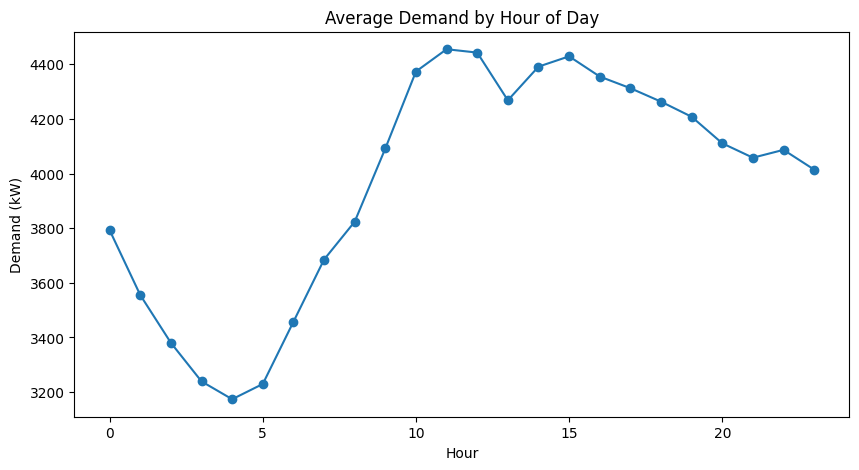

🔹 Insight: Peak electricity demand occurs around hour 11:00, likely evening usage.


In [34]:
plt.figure(figsize=(10,5))
hourly.groupby("hour")["Power demand"].mean().plot(marker="o")
plt.title("Average Demand by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Demand (kW)")
plt.show()
hourly_by_hour = hourly.groupby("hour")["Power demand"].mean()
peak_hour = hourly_by_hour.idxmax()
print(f"🔹 Insight: Peak electricity demand occurs around hour {peak_hour}:00, likely evening usage.")

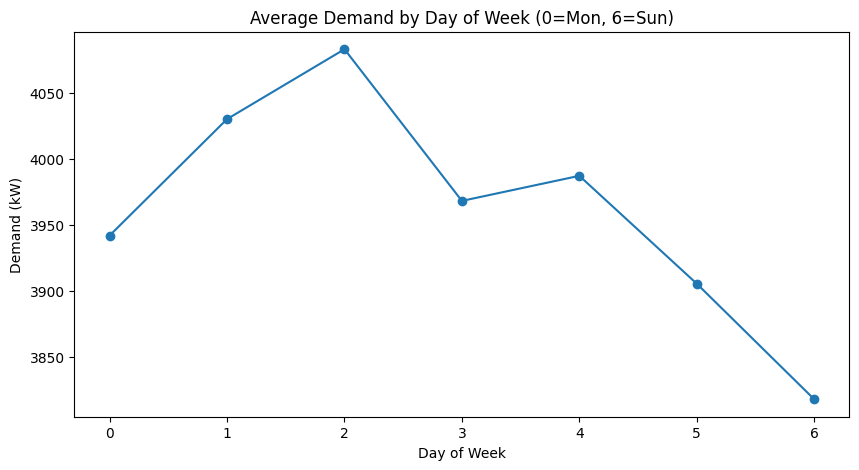

🔹 Insight: The highest average demand occurs on day 2 (0=Mon). Weekends may have lower demand.


In [35]:
plt.figure(figsize=(10,5))
hourly.groupby("day_of_week")["Power demand"].mean().plot(marker="o")
plt.title("Average Demand by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Demand (kW)")
plt.show()
weekday_avg = hourly.groupby("day_of_week")["Power demand"].mean()
highest_day = weekday_avg.idxmax()
print(f"🔹 Insight: The highest average demand occurs on day {highest_day} (0=Mon). Weekends may have lower demand.")

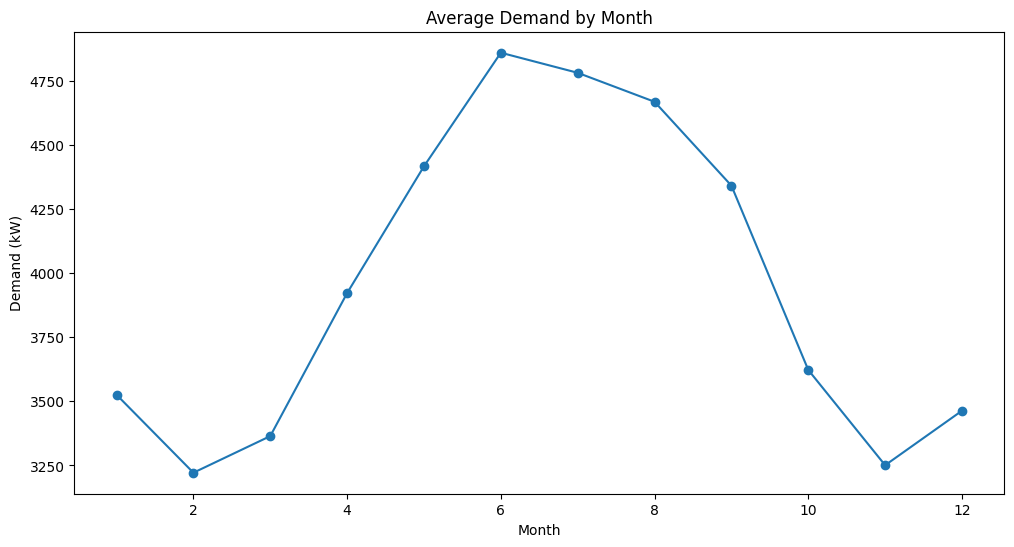

🔹 Insight: Peak demand occurs in month 6, possibly due to seasonal effects like heat/cooling needs.


In [36]:
plt.figure(figsize=(12,6))
hourly.groupby("month")["Power demand"].mean().plot(marker="o")
plt.title("Average Demand by Month")
plt.xlabel("Month")
plt.ylabel("Demand (kW)")
plt.show()
monthly_avg = hourly.groupby("month")["Power demand"].mean()
peak_month = monthly_avg.idxmax()
print(f"🔹 Insight: Peak demand occurs in month {peak_month}, possibly due to seasonal effects like heat/cooling needs.")

In [37]:
event_hours = hourly[hourly['is_festival'] == 1]
holiday_hours = hourly[hourly['is_holiday'] == 1]

In [38]:
peak_festival_demand = event_hours['Power demand'].max()
peak_festival_time = event_hours.loc[event_hours['Power demand'].idxmax(), 'datetime']


In [39]:
peak_holiday_demand = holiday_hours['Power demand'].max()
peak_holiday_time = holiday_hours.loc[holiday_hours['Power demand'].idxmax(), 'datetime']

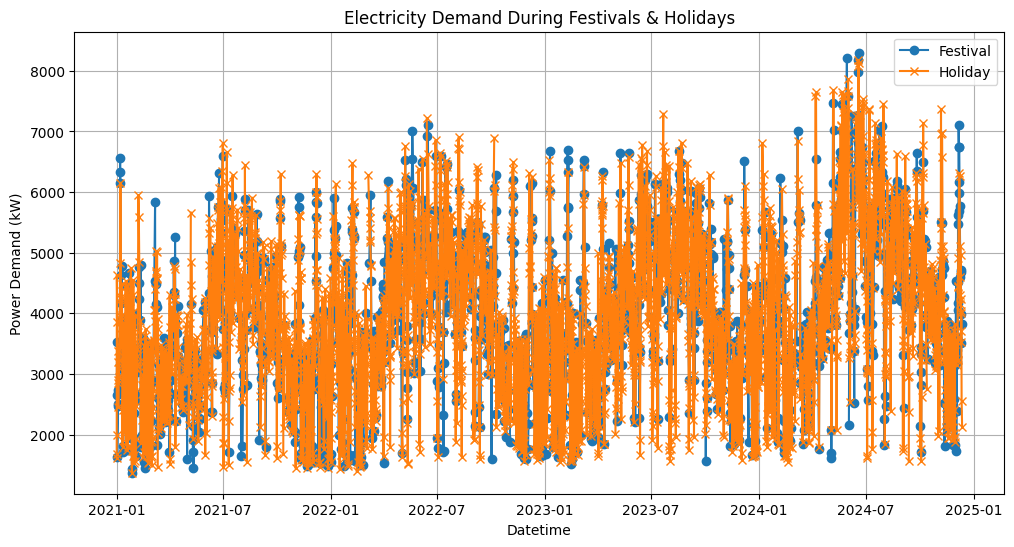

🔹 Insight 1: Peak demand during festival occurred at 2024-06-18 16:00:00 with 8298.83 kW.
🔹 Insight 2: Peak demand during holiday occurred at 2024-06-17 23:00:00 with 8171.36 kW.
🔹 Observation: Festivals generally show higher evening peaks due to celebrations and increased energy usage.


In [43]:
plt.figure(figsize=(12,6))
plt.plot(event_hours['datetime'], event_hours['Power demand'], label='Festival', marker='o')
plt.plot(holiday_hours['datetime'], holiday_hours['Power demand'], label='Holiday', marker='x')
plt.xlabel('Datetime')
plt.ylabel('Power Demand (kW)')
plt.title('Electricity Demand During Festivals & Holidays')
plt.legend()
plt.grid(True)
plt.show()         ## this is date-time grapgh.....for specific events/dates

print(f"🔹 Insight 1: Peak demand during festival occurred at {peak_festival_time} with {peak_festival_demand:.2f} kW.")
print(f"🔹 Insight 2: Peak demand during holiday occurred at {peak_holiday_time} with {peak_holiday_demand:.2f} kW.")
print("🔹 Observation: Festivals generally show higher evening peaks due to celebrations and increased energy usage.")

In [45]:
hourly['hour'] = hourly['datetime'].dt.hour
festival_hourly = hourly[hourly['is_festival']==1].groupby('hour')['Power demand'].mean()
normal_hourly = hourly[hourly['is_festival']==0].groupby('hour')['Power demand'].mean()


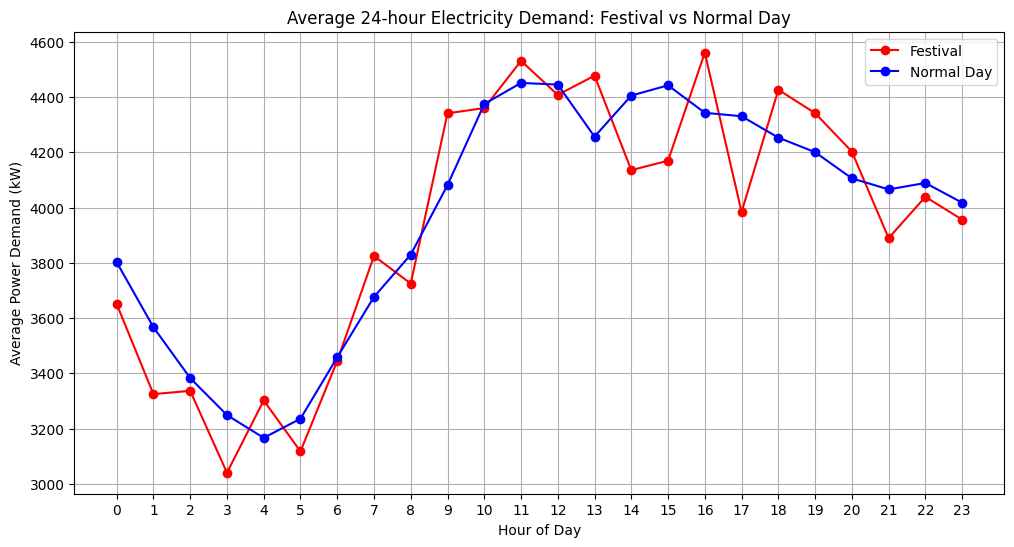

🔹 Insight: Peak demand during festival occurs at 16:00 hour.
🔹 Insight: Peak demand on normal day occurs at 11:00 hour.
Observation: Festivals generally have higher evening demand compared to normal days.


In [46]:
plt.figure(figsize=(12,6))
plt.plot(festival_hourly.index, festival_hourly.values, label='Festival', marker='o', color='red')
plt.plot(normal_hourly.index, normal_hourly.values, label='Normal Day', marker='o', color='blue')
plt.xticks(range(0,24))
plt.xlabel('Hour of Day')
plt.ylabel('Average Power Demand (kW)')
plt.title('Average 24-hour Electricity Demand: Festival vs Normal Day')
plt.legend()
plt.grid(True)
plt.show()              ## average 24 hour profile for general comparisons/trends

peak_hour_festival = festival_hourly.idxmax()
peak_hour_normal = normal_hourly.idxmax()
print(f"🔹 Insight: Peak demand during festival occurs at {peak_hour_festival}:00 hour.")
print(f"🔹 Insight: Peak demand on normal day occurs at {peak_hour_normal}:00 hour.")
print("Observation: Festivals generally have higher evening demand compared to normal days.")